# Imports

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tf_keras as k
from tf_keras.layers import *
from tf_keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

from modules import train_model, evaluate_preds, save_dict_to_json, get_results_table

# Dataset

In [3]:
PATH = 'data/'
columns_to_drop = ['Date', 'Open', 'High', 'Low', 'Close + 7', 'Close + 8', 'Close + 9', 'Close + 10', 'Close + 11',
       'Close + 12', 'Close + 13', 'Close + 14', 'Close + 15',
       'Close + 16', 'Close + 17', 'Close + 18', 'Close + 19',
       'Close + 20', 'Close + 21', 'Close + 22', 'Close + 23',
       'Close + 24', 'Close + 25', 'Close + 26', 'Close + 27',
       'Close + 28', 'Close + 29', 'Close + 30']
train_df = pd.read_csv(PATH+'train_dataset.csv').drop(columns=columns_to_drop)
valid_df = pd.read_csv(PATH+'valid_dataset.csv').drop(columns=columns_to_drop)
test_df = pd.read_csv(PATH+'test_dataset.csv').drop(columns=columns_to_drop)

In [4]:
scaler = MinMaxScaler()
columns_to_scale = ['Volume', 'value', 'Close + 1',
       'Close + 2', 'Close + 3', 'Close + 4', 'Close + 5', 'Close + 6',
        'MA_13', 'MA_21',
       'RSI_3', '%K', '%D', 'Close']
train_df[columns_to_scale] = scaler.fit_transform(train_df[columns_to_scale])
valid_df[columns_to_scale] = scaler.transform(valid_df[columns_to_scale])
test_df[columns_to_scale] = scaler.transform(test_df[columns_to_scale])

X_train, y_train = np.array(train_df.iloc[:, :-1]), np.array(train_df.iloc[:, -1]) 
X_valid, y_valid = np.array(valid_df.iloc[:, :-1]), np.array(valid_df.iloc[:, -1]) 
X_test, y_test = np.array(test_df.iloc[:, :-1]), np.array(test_df.iloc[:, -1])

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_valid = np.reshape(X_valid, (X_valid.shape[0], 1, X_valid.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [5]:
# Fast save function
def fast_save(model, model_name):
    y_train_pred = model.predict(X_train, verbose=0)
    y_valid_pred = model.predict(X_valid, verbose=0)
    y_test_pred = model.predict(X_test, verbose=0)
    save_dict_to_json(evaluate_preds(y_train, y_train_pred), filename=f'results/train/{model_name}.json')
    save_dict_to_json(evaluate_preds(y_valid, y_valid_pred), filename=f'results/valid/{model_name}.json')
    save_dict_to_json(evaluate_preds(y_test, y_test_pred), filename=f'results/test/{model_name}.json')

# Training

## Hyperparameters

In [6]:
callback = [k.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')]
metrics=[k.metrics.MeanSquaredError(), 
         k.metrics.RootMeanSquaredError(),
         k.metrics.MeanAbsolutePercentageError(),
         k.metrics.MeanAbsoluteError()]
loss_fn = k.losses.MeanSquaredError()

## BiLSTM-128

In [7]:
tf.random.set_seed(42)
bilstm128 = Sequential([
    Bidirectional(LSTM(units=128, 
                       input_shape=(1, X_train.shape[2]), 
                       activation='relu')),
    Dense(1),
])

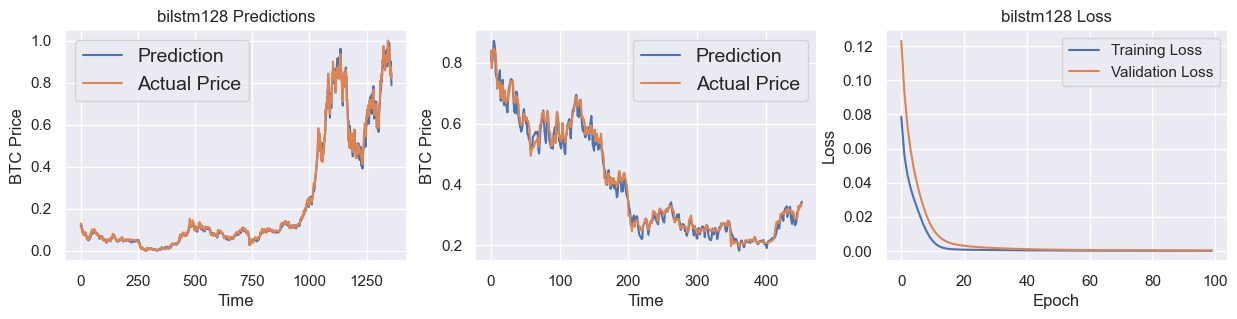

In [8]:
tf.random.set_seed(42)
bilstm128_history = train_model(
    model=bilstm128,
    model_name='bilstm128',
    loss_fn=loss_fn,
    optimizer=k.optimizers.Adam(learning_rate=1e-4),
    metrics=metrics,
    X_train=X_train,
    y_train=y_train, 
    batch_size=32,
    epochs=100,
    validation_data=(X_valid, y_valid),
    shuffle=False,
    verbose=0,
    callbacks=callback
)
fast_save(bilstm128, 'bilstm128')

In [9]:
get_results_table('results/valid')

,mae,mse,rmse,mape,mase,model
0,0.013748,0.000336,0.013748,3.542995,18.622242,bilstm128
1,0.013044,0.000292,0.013044,3.466840,18.664600,bilstm256
2,0.014755,0.000387,0.014755,3.834195,18.739326,ed_bilstm128
3,0.024368,0.000986,0.024368,6.338571,18.495451,model_0_LSTM
4,0.016200,0.000436,0.016200,4.278743,18.587181,model_1_BiLSTM
5,0.197580,0.064334,0.247453,53.959656,18.916525,model_2_EDLSTM
6,0.018594,0.000531,0.018594,5.249279,18.859989,model_3_ConvLSTM
7,0.010445,0.000267,0.016341,2.548672,1.010110,naive


# BiLSTM-256

In [10]:
tf.random.set_seed(42)
bilstm256 = Sequential([
    Bidirectional(LSTM(units=256, 
                       input_shape=(1, X_train.shape[2]), 
                       activation='relu')),
    Dense(1),
])

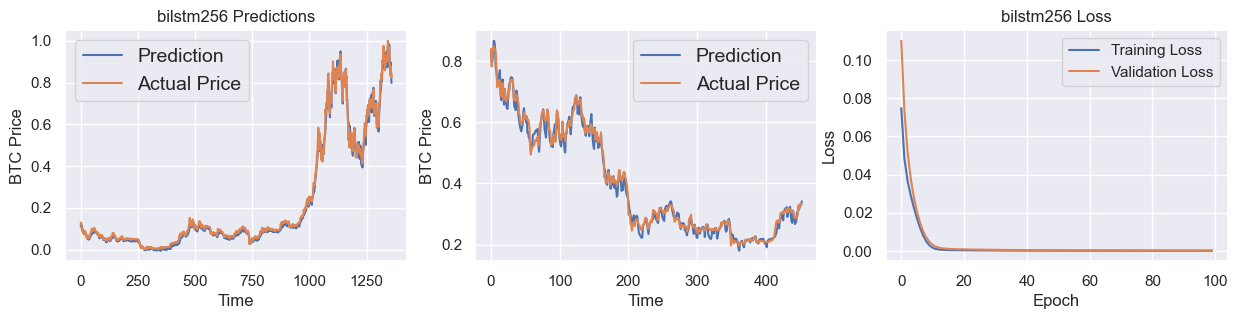

In [11]:
tf.random.set_seed(42)
bilstm256_history = train_model(
    model=bilstm256,
    model_name='bilstm256',
    loss_fn=loss_fn,
    optimizer=k.optimizers.Adam(learning_rate=1e-4),
    metrics=metrics,
    X_train=X_train,
    y_train=y_train, 
    batch_size=32,
    epochs=100,
    validation_data=(X_valid, y_valid),
    shuffle=False,
    verbose=0,
    callbacks=callback
)
fast_save(bilstm256, 'bilstm256')

In [12]:
get_results_table('results/valid')

,mae,mse,rmse,mape,mase,model
0,0.013748,0.000336,0.013748,3.542995,18.622242,bilstm128
1,0.013029,0.000296,0.013029,3.428860,18.651741,bilstm256
2,0.014755,0.000387,0.014755,3.834195,18.739326,ed_bilstm128
3,0.024368,0.000986,0.024368,6.338571,18.495451,model_0_LSTM
4,0.016200,0.000436,0.016200,4.278743,18.587181,model_1_BiLSTM
5,0.197580,0.064334,0.247453,53.959656,18.916525,model_2_EDLSTM
6,0.018594,0.000531,0.018594,5.249279,18.859989,model_3_ConvLSTM
7,0.010445,0.000267,0.016341,2.548672,1.010110,naive


## LSTM - BiLSTM

In [16]:
tf.random.set_seed(42)
l_bilstm256 = Sequential([
    Bidirectional(LSTM(units=256, 
                       input_shape=(1, X_train.shape[2]), 
                       activation='relu',
                        return_sequences=True)),
    LSTM(units=256, 
         input_shape=(1, X_train.shape[2]), 
         activation='relu'),
    Dense(1),
])

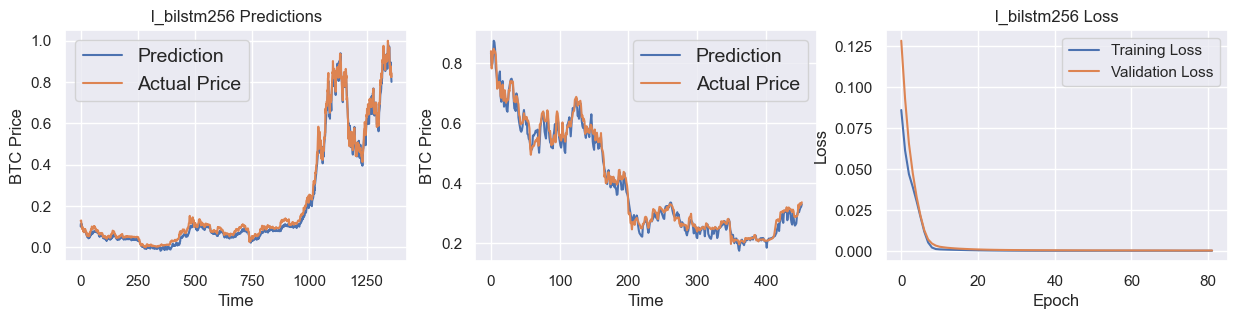

In [17]:
tf.random.set_seed(42)
l_bilstm256_history = train_model(
    model=l_bilstm256,
    model_name='l_bilstm256',
    loss_fn=loss_fn,
    optimizer=k.optimizers.Adam(learning_rate=1e-4),
    metrics=metrics,
    X_train=X_train,
    y_train=y_train, 
    batch_size=32,
    epochs=100,
    validation_data=(X_valid, y_valid),
    shuffle=False,
    verbose=0,
    callbacks=callback
)
fast_save(l_bilstm256, 'l_bilstm256')

In [18]:
get_results_table('results/valid')

,mae,mse,rmse,mape,mase,model
0,0.013748,0.000336,0.013748,3.542995,18.622242,bilstm128
1,0.013029,0.000296,0.013029,3.428860,18.651741,bilstm256
2,0.014755,0.000387,0.014755,3.834195,18.739326,ed_bilstm128
3,0.014522,0.000363,0.014522,3.811408,18.671261,l_bilstm256
4,0.024368,0.000986,0.024368,6.338571,18.495451,model_0_LSTM
5,0.016200,0.000436,0.016200,4.278743,18.587181,model_1_BiLSTM
6,0.197580,0.064334,0.247453,53.959656,18.916525,model_2_EDLSTM
7,0.018594,0.000531,0.018594,5.249279,18.859989,model_3_ConvLSTM
8,0.010445,0.000267,0.016341,2.548672,1.010110,naive
